In [1]:
# https://gis.stackexchange.com/a/363527
import matplotlib
import matplotlib.pyplot as plt
import requests
import urllib
import codecs
import json
from osm2geojson import json2geojson
import pyproj
import math
import pandas as pd
import itertools

OVERPASS = "https://overpass-api.de/api/interpreter/"

def overpass_call(query):
    encoded = urllib.parse.quote(query.encode('utf-8'), safe='~()*!.\'')
    r = requests.post(OVERPASS,
                      data=f"data={encoded}",
                      headers={'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8'})
    if r.status_code != 200:
        raise requests.exceptions.HTTPError('Overpass server respond with status '+str(r.status_code))
    return r.text


def save_data(data, geom_file):
    json_data = json.dumps(data, indent=2)
    f = codecs.open(geom_file, 'w')
    f.write(json_data)
    f.close()

# fetch all ways and nodes
data = overpass_call(f"""
    [out:json];
    rel(284560);
    out geom;
""")

geojson_data = json2geojson(data)
save_data(geojson_data, 'circuit.geojson')

# https://gis.stackexchange.com/questions/298929/converting-lat-lon-to-x-y-coordinates-with-pyproj
# Found the UTM zone for daytona via https://mangomap.com/robertyoung/maps/69585/what-utm-zone-am-i-in-#
# OSM data uses WGS84 https://wiki.openstreetmap.org/wiki/Converting_to_WGS84

P = pyproj.Proj(proj='utm', zone=17, ellps='WGS84', preserve_units=True)
G = pyproj.Geod(ellps='WGS84')

def LatLon_To_XY(Lat,Lon):
    return P(Lat,Lon)    

def XY_To_LatLon(x,y):
    return P(x,y,inverse=True)

with open('circuit.geojson') as json_file:
    data = json.load(json_file)

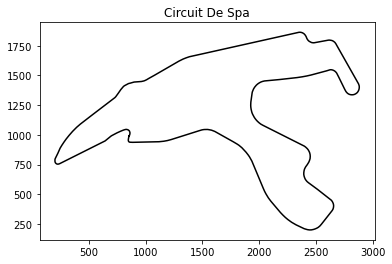

In [2]:
features = data['features'][0]['geometry']['coordinates']
del features[0] # getting rid of pit lane
coords = list(itertools.chain.from_iterable(features))
cartesian_coords = map(lambda coord: list(LatLon_To_XY(coord[0], coord[1])), coords)
cartesian_coords = list(cartesian_coords)
df = pd.DataFrame(data=cartesian_coords)
nodes = list(map(lambda coord: [coord[0]-df[0].min()+200, coord[1]-df[1].min()+200, 1], cartesian_coords))
df1 = pd.DataFrame(data=nodes)

plt.title("Circuit De Spa")
plt.plot(df1[0], df1[1], color='black');